# 使用 SQL 回答问题

 > 构建一个问题回答系统，执行 SQL 查询以告知其响应。

## 构建一个基于 SQL 数据的问答系统（Build a Question/Answering System over SQL Data）

### 内容概述

让一个大语言模型（LLM）系统查询**结构化数据**，与处理非结构化文本数据有本质区别。

在处理非结构化文本时，通常的做法是生成嵌入（embeddings），然后在向量数据库中进行语义搜索。  
而在处理**结构化数据**（如关系型数据库中的表格数据）时，常见做法是让 LLM 生成并执行一种**领域特定语言（DSL）** 的查询，例如 **SQL**。

在本指南中，我们将介绍如何在数据库中的表格数据上构建一个基本的问答系统（Q&A system）。我们会分别使用：

- **Chains（链式调用）**
- **Agents（智能体）**

这两种方式都能让我们对数据库中的数据提出自然语言问题，并获得自然语言形式的答案。

它们之间的主要区别在于：

- 使用 **Chain** 时，我们通常只执行一次预定义的 SQL 查询；
- 使用 **Agent** 时，它可以**循环多次查询数据库**，直到获取足够的信息来回答问题。

### ⚠️ 安全提示 ⚠️

构建基于 SQL 数据库的问答系统，通常需要**执行由模型生成的 SQL 查询语句**。这种做法存在**固有的安全风险**。

为降低风险，请务必确保：

> 你的数据库连接权限应**尽可能最小化**，仅授予你的 Chain（链）或 Agent（智能体）**实际需要的访问权限**。

这样虽然不能完全消除模型驱动系统所带来的风险，但可以**显著提高安全性**。

例如：

- 不要使用具有写权限或管理权限的数据库账户；
- 限制对敏感表或字段的访问；
- 使用只读用户账号进行查询；
- 对生成的 SQL 进行校验或过滤（如白名单机制）；

### 架构（Architecture）

从高层次来看，这类系统的执行步骤通常包括：

1. **将问题转换为 SQL 查询**：  
   由模型将用户的自然语言问题转化为对应的 SQL 查询语句。

2. **执行 SQL 查询**：  
   在数据库中执行生成的 SQL 语句，获取相关数据结果。

3. **根据查询结果回答问题**：  
   模型使用查询返回的数据，生成自然语言的回答，反馈给用户。

---

### 补充说明：

请注意，这种处理方式同样适用于对 **CSV 文件中的结构化数据** 进行查询。  
如果你希望了解如何构建基于 CSV 数据的问答系统，可以参考我们的指南：  
👉 [如何构建基于 CSV 数据的问答系统（How-to guide on question-answering over CSV data）](https://python.langchain.com/docs/how_to/sql_csv/)


![示例图片](../../assets/imgs/sql_usecase.png)  

### 示例数据（Sample Data）

下面的示例将使用一个 **SQLite 数据库连接**，并基于 **Chinook 数据库** 进行操作。  
Chinook 是一个示例数据库，它模拟了一个数字音像商店（Digital Media Store）的业务数据。

请按照以下安装步骤，在**与当前 Notebook 相同的目录下**创建 `Chinook.db` 文件。  
你也可以通过命令行下载并构建该数据库：

---

### ✅ 安装步骤（Installation Steps）

sqlite3 下载链接：https://sqlite.org/2025/sqlite-tools-win-x64-3500100.zip

```bash
# 下载 Chinook SQLite 数据库文件
curl -s https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sql | sqlite3 Chinook.db

```

这样你就可以在 Python 代码中轻松连接和使用这个数据库了。


In [2]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM Artist LIMIT 10;")

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"

我们现在有了一个可以查询的 SQL 数据库。现在，让我们尝试将它连接到一个大语言模型（LLM）上。

### Chains（链式调用）

**Chains（链）** 是由一系列可预测的步骤组合而成。在 LangGraph 中，我们可以通过简单的节点序列来表示一个 Chain。

下面我们创建一个流程，它接收一个问题，并依次执行以下步骤：

1. **将问题转换为 SQL 查询**；
2. **执行该 SQL 查询**；
3. **使用查询结果回答原始问题**。

---

### ⚠️ 局限性说明

这种结构并不能处理所有场景，例如：

- 它会对**任何用户输入**都尝试生成并执行 SQL 查询，即使输入是像 `"hello"` 这样的问候语；
- 有些问题需要**多次数据库查询**才能回答完整（比如涉及多个表或多个逻辑步骤的问题）。

这些问题我们将在后面的 **Agents（智能体）** 部分中解决。

---

### 应用状态（Application State）

LangGraph 中的应用状态（State）决定了：

- 哪些数据作为输入传入应用；
- 步骤之间传递哪些信息；
- 最终输出哪些内容。

通常我们会使用 `TypedDict` 来定义状态结构，也可以使用 Pydantic 的 `BaseModel`。

---

### 本例中的状态定义

对于当前这个基于 SQL 的问答系统，我们的状态可以包含以下字段：

```python
from typing import TypedDict

class State(TypedDict):
    question: str           # 用户提出的问题
    sql_query: str          # 生成的 SQL 查询语句
    result_of_query: str    # 查询返回的结果
    answer: str             # 最终生成的回答
```

这样，我们就可以在每个节点中逐步填充这些字段，完成整个流程。

In [3]:
from typing_extensions import TypedDict


class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str

现在我们只需要编写一些函数来操作这个状态（State），并逐步填充它的内容即可。

---

### 第一步：将问题转换为 SQL 查询

我们需要的第一个功能是：**接收用户的自然语言问题，并将其转化为对应的 SQL 查询语句**。

为了**稳定、可靠地获取纯 SQL 查询结果**（避免包含 Markdown 格式、解释性文字或其他多余内容），我们将使用 **LangChain 的结构化输出抽象（structured output abstraction）**。

这意味着我们可以定义一个输出格式（例如只返回 SQL 查询字符串），并让模型严格按照该格式输出，从而提升准确性和可控性。


In [4]:
import getpass
import os

try:
    # load environment variables from .env file (requires `python-dotenv`)
    from dotenv import load_dotenv

    _ = load_dotenv()
except ImportError:
    pass

if not os.environ.get("DASHSCOPE_API_KEY"):
  os.environ["DASHSCOPE_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain_community.chat_models.tongyi import ChatTongyi

llm  = ChatTongyi(
    streaming=True,
    name="qwen-turbo"
)

In [5]:
from langchain_core.prompts import ChatPromptTemplate

system_message = """
Given an input question, create a syntactically correct {dialect} query to
run to help find the answer. Unless the user specifies in his question a
specific number of examples they wish to obtain, always limit your query to
at most {top_k} results. You can order the results by a relevant column to
return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the
few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema
description. Be careful to not query for columns that do not exist. Also,
pay attention to which column is in which table.

Only use the following tables:
{table_info}
"""

user_prompt = "Question: {input}"

query_prompt_template = ChatPromptTemplate(
    [("system", system_message), ("user", user_prompt)]
)

for message in query_prompt_template.messages:
    message.pretty_print()

================================ System Message ================================


Given an input question, create a syntactically correct {dialect} query to
run to help find the answer. Unless the user specifies in his question a
specific number of examples they wish to obtain, always limit your query to
at most {top_k} results. You can order the results by a relevant column to
return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the
few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema
description. Be careful to not query for columns that do not exist. Also,
pay attention to which column is in which table.

Only use the following tables:
{table_info}

================================ Human Message =================================

Question: {input}


这个提示词（prompt）中包含了一些我们需要填充的参数，例如 SQL 方言（dialect）和表结构（table schemas）。  
LangChain 的 `SQLDatabase` 对象提供了一些方法来帮助我们获取这些信息。

在我们的 **write_query** 步骤中，只需要将这些参数填入提示词模板中，然后让模型生成对应的 SQL 查询语句即可：

In [11]:
from typing_extensions import Annotated


class QueryOutput(TypedDict):
    """Generated SQL query."""

    query: Annotated[str, ..., "Syntactically valid SQL query."]


def write_query(state: State):
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state["question"],
        }
    )
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"]}

In [7]:
write_query({"question": "How many Employees are there?"})

{'query': 'SELECT COUNT(*) AS NumberOfEmployees FROM Employee'}

### 执行查询（Execute Query）

这是构建 SQL Chain（链）过程中**最危险的一步**。

在执行前，请**务必谨慎评估是否允许对你的数据自动执行查询**。为了降低风险：

- 应尽可能**最小化数据库连接权限**（例如使用只读账户）；
- 可以考虑在执行查询前加入一个**人工审批步骤**；

---

### 实现方式

为了执行 SQL 查询，我们将从 `langchain-community` 中加载一个工具（tool）。  
我们创建的 `execute_query` 节点只需封装这个工具即可：


In [8]:
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool


def execute_query(state: State):
    """Execute SQL query."""
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}

In [9]:
execute_query({"query": "SELECT COUNT(EmployeeId) AS EmployeeCount FROM Employee;"})

{'result': '[(8,)]'}

### 生成答案（Generate Answer）

最后，我们的最后一个步骤是：**根据从数据库中检索到的信息，生成对原始问题的自然语言回答**。

这一步通常由语言模型（LLM）完成，它会将结构化的查询结果（如表格数据或聚合数值）转化为易于理解的回答。


In [10]:
def generate_answer(state: State):
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}

### 使用 LangGraph 进行流程编排（Orchestrating with LangGraph）

最后，我们将整个应用程序**编译成一个图对象（graph object）**。  
在本例中，我们只是将前面定义的三个步骤按顺序连接起来，形成一个**线性的执行流程**。


In [12]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence(
    [write_query, execute_query, generate_answer]
)
graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile()

LangGraph 还内置了用于可视化你的应用程序控制流程的工具：

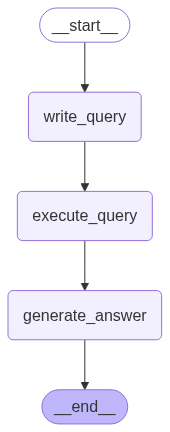

In [13]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

让我们来测试我们的应用程序！请注意，我们可以流式传输各个步骤的结果：

In [14]:
for step in graph.stream(
    {"question": "How many employees are there?"}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': 'SELECT COUNT(*) AS NumberOfEmployees FROM Employee'}}
{'execute_query': {'result': '[(8,)]'}}
{'generate_answer': {'answer': 'There are 8 employees.'}}


### 人机协同循环（Human-in-the-loop）  
LangGraph 支持多项对此工作流有用的特性。其中之一便是“人机协同循环”：我们可以在某些敏感步骤（例如执行 SQL 查询）之前中断应用程序，以供人工审核。  
这一功能由 LangGraph 的持久化层实现，它可以将运行进度保存到你选择的存储中。  
以下示例中，我们指定使用内存中的存储：

In [15]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory, interrupt_before=["execute_query"])

# Now that we're using persistence, we need to specify a thread ID
# so that we can continue the run after review.
config = {"configurable": {"thread_id": "1"}}

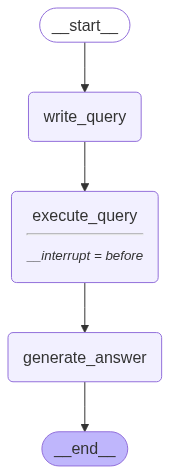

In [16]:
display(Image(graph.get_graph().draw_mermaid_png()))

让我们重复相同的运行过程，并添加一个简单的“是/否”审批步骤：
```
INSERT INTO [Track] ([TrackId], [Name], [AlbumId], [MediaTypeId], [GenreId], [Composer], [Milliseconds], [Bytes], [UnitPrice]) VALUES
    (1, 'For Those About To Rock (We Salute You)', 1, 1, 1, 'Angus Young, Malcolm Young, Brian Johnson', 343719, 11170334, 0.99),
    (2, 'Balls to the Wall', 2, 2, 1, 'U. Dirkschneider, W. Hoffmann, H. Frank, P. Baltes, S. Kaufmann, G. Hoffmann', 342562, 5510424, 0.99),

INSERT INTO [Genre] ([GenreId], [Name]) VALUES
    (1, 'Rock'),
    (2, 'Jazz'),
    (3, 'Metal'),
    (4, 'Alternative & Punk'),
    (5, 'Rock And Roll'),
    (6, 'Blues'),
    (7, 'Latin'),
    (8, 'Reggae'),
    (9, 'Pop'),
```

In [18]:
for step in graph.stream(
    {"question": "有多少首摇滚曲目?"},
    config,
    stream_mode="updates",
):
    print(step)

try:
    user_approval = input("您想去执行查询吗？（是/否）： ")
except Exception:
    user_approval = "n"

if user_approval.lower() == "y":
    # If approved, continue the graph execution
    for step in graph.stream(None, config, stream_mode="updates"):
        print(step)
else:
    print("操作被用户取消。")

{'write_query': {'query': 'SELECT COUNT(*) AS RockSongsCount FROM Track WHERE GenreId = 1'}}
{'__interrupt__': ()}


您想去执行查询吗？（是/否）：  y


{'execute_query': {'result': '[(1297,)]'}}
{'generate_answer': {'answer': '有 **1297** 首摇滚曲目。'}}


### 智能代理（Agents）

智能代理利用大语言模型（LLMs）的推理能力，在执行过程中进行决策。使用代理可以将查询生成和执行过程中的更多判断权交给模型。虽然它们的行为相比前述“链式”方法（chain）更不可预测，但它们也具有一些优势：

- 它们可以根据需要多次查询数据库，以回答用户的问题。  
- 它们可以通过运行生成的查询、捕获错误回溯并重新生成正确查询来从错误中恢复。  
- 它们可以根据数据库的结构（schema）以及数据库中的内容来回答问题（例如描述某个特定表的结构）。  

下面我们构建一个最简单的 SQL 代理。我们将使用 LangChain 的 `SQLDatabaseToolkit` 为其配备一组工具。借助 LangGraph 预构建的 ReAct 代理构造器，我们可以在一行代码中完成这一操作。

SQLDatabaseToolkit 包含以下功能的工具：

- 创建并执行查询  
- 检查查询语法  
- 获取表的描述  
- 以及其他更多功能

In [19]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=llm)

tools = toolkit.get_tools()

tools

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000001CE24DADDD0>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000001CE24DADDD0>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000001CE24DADDD0>),
 QuerySQLCheckerTool(description='Use this tool to 

**系统提示词（System Prompt）**

我们还希望为智能体加载一个系统提示词。这将包含代理应遵循的行为指令。请注意，下面的提示词包含多个参数，我们将在下方进行赋值。

In [31]:
# 你是一个专门用于与 SQL 数据库交互的代理。
# 根据输入的问题，生成一个语法正确的 {dialect} 查询语句并执行，
# 然后查看查询结果并返回答案。除非用户明确指定了想要获取的具体示例数量，
# 否则你的查询结果最多限制为 {top_k} 条。
# 你可以通过相关列对结果进行排序，以返回数据库中最有意义的示例。
# 不要从某个特定表中查询所有列，只选择与问题相关的列进行查询。
# 在执行查询之前，你必须仔细检查你的查询语句。如果在执行过程中出现错误，
# 请重写查询并再次尝试。
# 禁止向数据库发送任何数据操作语言（DML）语句（如 INSERT、UPDATE、DELETE、DROP 等）。
# 开始时，你始终应该首先查看数据库中的表，了解你可以查询哪些内容。
# 不要跳过这一步。
# 接着，你应该查询最相关表的结构（schema）。

system_message = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

You MUST double check your query before executing it. If you get an error while
executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the
database.

To start you should ALWAYS look at the tables in the database to see what you
can query. Do NOT skip this step.

Then you should query the schema of the most relevant tables.
""".format(
    dialect="SQLite",
    top_k=5,
)

**初始化智能体**

我们将使用一个预构建的 LangGraph 代理来创建我们的代理。

In [21]:
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, tools, prompt=system_message)

In [22]:
question = "哪个国家的客户花费最多?"

for step in agent_executor.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

哪个国家的客户花费最多?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_4df5b22b68d54e9e89753dcall_4df5b22b68d54e9e89753d)
 Call ID: call_4df5b22b68d54e9e89753dcall_4df5b22b68d54e9e89753d
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_a9c0ee4a7bd14736ac6d76call_a9c0ee4a7bd14736ac6d76call_a9c0ee4a7bd14736ac6d76call_a9c0ee4a7bd14736ac6d76)
 Call ID: call_a9c0ee4a7bd14736ac6d76call_a9c0ee4a7bd14736ac6d76call_a9c0ee4a7bd14736ac6d76call_a9c0ee4a7bd14736ac6d76
  Args:
    table_names: Customer
================================= Tool Message ============================

请注意，该代理会执行多个查询，直到获得所需的信息为止：

- 列出可用的表；
- 获取三个表的结构（schema）；
- 通过连接操作（join）查询多个表。

代理随后可以利用最终查询的结果来生成对原始问题的回答。

该代理同样可以处理定性类问题：

In [23]:
question = "描述播放列表曲目"

for step in agent_executor.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

描述播放列表曲目
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_6c7963dc6d5f415db0485bcall_6c7963dc6d5f415db0485b)
 Call ID: call_6c7963dc6d5f415db0485bcall_6c7963dc6d5f415db0485b
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================

在数据库中存在多个表，其中可能与播放列表曲目相关的表有Playlist, Track和PlaylistTrack。为了查询播放列表中的曲目信息，我们需要查看这些表的结构。

接下来，我将查询这些表的结构。
Tool Calls:
  sql_db_schema (call_63f1049c54cf4fd7956825call_63f1049c54cf4fd7956825call_63f1049c54cf4fd7956825call_63f1049c54cf4fd7956825call_63f1049c54cf4fd7956825)
 Call ID: call_63f1049c54cf4fd7956825call_63f1049c54cf4fd7956825call_63f1049c54cf4fd7956825call_63f10

**处理高基数列（High-cardinality Columns）**

为了对包含专有名词（如地址、歌曲名或艺术家名）的列进行筛选，我们首先需要检查拼写是否正确，以便准确地过滤数据。

我们可以通过创建一个包含数据库中所有不同专有名词的向量存储（vector store）来实现这一点。然后，每当用户在问题中使用了一个专有名词时，我们可以让代理查询这个向量存储，以找到该词的正确拼写。通过这种方式，代理可以在构建目标查询之前，确保自己理解用户所指的是哪个实体。

首先，我们需要获取每个想要的实体的唯一值，为此我们定义一个函数，将查询结果解析为元素列表：

In [24]:
import ast
import re


def query_as_list(db, query):
    res = db.run(query)
    res = [el for sub in ast.literal_eval(res) for el in sub if el]
    res = [re.sub(r"\b\d+\b", "", string).strip() for string in res]
    return list(set(res))


artists = query_as_list(db, "SELECT Name FROM Artist")
albums = query_as_list(db, "SELECT Title FROM Album")
albums[:5]

['A TempestadeTempestade Ou O Livro Dos Dias',
 'The Number of The Beast',
 'Bach: Toccata & Fugue in D Minor',
 'Vozes do MPB',
 'Bach: Orchestral Suites Nos.  -']

#### 逐行解析：

- `res = db.run(query)`  
  执行传入的 SQL 查询语句，并将结果保存在 `res` 中。  
  假设返回的是字符串形式的结果，比如类似 `[('Artist1',), ('Artist2',)]` 的结构。

- `res = [el for sub in ast.literal_eval(res) for el in sub if el]`  
  使用 `ast.literal_eval()` 将字符串形式的结果转换为 Python 列表/元组结构，  
  然后通过列表推导式提取每个子项中的元素（例如 `'Artist1'`），并过滤掉空值。

- `res = [re.sub(r"\b\d+\b", "", string).strip() for string in res]`  
  使用正则表达式去掉字符串中的独立数字（`\b\d+\b` 表示被单词边界包围的数字），  
  然后使用 `.strip()` 去除首尾的空白字符。

- `return list(set(res))`  
  返回一个去重后的列表（通过 `set` 去重，再转回 `list`）。

---

### **3. 查询数据库中的艺术家和专辑名称**

```python
artists = query_as_list(db, "SELECT Name FROM Artist")
albums = query_as_list(db, "SELECT Title FROM Album")
```

- 这两行分别从数据库中查询出所有艺术家的名字和专辑的标题，并调用 `query_as_list` 函数对结果进行清洗和去重。

---

### **4. 显示前5个专辑标题**

```python
albums[:5]
```

- 显示 `albums` 列表中的前5个元素，通常用于快速查看数据内容。

---

### ✅ 总结

这段代码的主要作用是：

1. 从数据库中查询出艺术家名和专辑标题；
2. 清洗这些数据（如去除数字、空值）；
3. 去重后以列表形式返回；
4. 最后展示部分结果以便检查。

这在构建向量存储或实体识别系统时非常有用，尤其是在处理高基数列（如歌曲名、艺术家名等）时。

In [26]:
from langchain_community.embeddings.dashscope import DashScopeEmbeddings
# 初始化 Qwen Embedding 模型
embeddings = DashScopeEmbeddings(model="text-embedding-v1")  

In [27]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

我们现在可以构建一个检索工具，可以搜索数据库中的相关专有名词：

In [28]:
from langchain.agents.agent_toolkits import create_retriever_tool

_ = vector_store.add_texts(artists + albums)
retriever = vector_store.as_retriever(search_kwargs={"k": 5})
# 用于查找需要过滤的值。输入是对专有名词的近似拼写，输出是有效的专有名词。请使用与搜索词最相似的名词。
description = (
    "Use to look up values to filter on. Input is an approximate spelling "
    "of the proper noun, output is valid proper nouns. Use the noun most "
    "similar to the search."
)
retriever_tool = create_retriever_tool(
    retriever,
    name="search_proper_nouns",
    description=description,
)

In [29]:
print(retriever_tool.invoke("Alice Chains"))

Alice In Chains

Adrian Leaper & Doreen de Feis

Chill: Brazil (Disc )

Elis Regina-Minha História

Christina Aguilera featuring BigElf


这样，如果代理确定需要按照“Alice Chains”的思路编写基于艺术家的过滤器，它可以首先使用检索器工具来观察列的相关值。

将其放在一起：

In [32]:
# 如果需要根据专有名词（如名称）进行过滤，你必须始终首先使用 `search_proper_nouns` 工具查找过滤值！
# 不要尝试猜测正确的名称——请使用这个工具来查找相似的名称。”
suffix = (
    "If you need to filter on a proper noun like a Name, you must ALWAYS first look up "
    "the filter value using the 'search_proper_nouns' tool! Do not try to "
    "guess at the proper name - use this function to find similar ones."
)

system = f"{system_message}\n\n{suffix}"

tools.append(retriever_tool)

agent = create_react_agent(llm, tools, prompt=system)

In [33]:
question = "Alis in chain 有多少张专辑?"

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Alis in chain 有多少张专辑?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_f54cd9445610451cad794ccall_f54cd9445610451cad794c)
 Call ID: call_f54cd9445610451cad794ccall_f54cd9445610451cad794c
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_11e127a668724e28a4d7bccall_11e127a668724e28a4d7bccall_11e127a668724e28a4d7bccall_11e127a668724e28a4d7bc)
 Call ID: call_11e127a668724e28a4d7bccall_11e127a668724e28a4d7bccall_11e127a668724e28a4d7bccall_11e127a668724e28a4d7bc
  Args:
    table_names: Album
================================= Tool Message ======================